# Plot spatial heat maps

## Init & get data
Collect leadership values & corresponding positions

In [1]:
# imports

import numpy as np
import pickle
import pandas as pd
import warnings
import pickle

import config
from utils.plot_spatial_heatmap import *

In [2]:
# set parameters

# ===== CHANGE THIS ===================================
# specify grid width (m or SD) in spatial heatmaps
grid_width = {}
grid_width['m'] = 0.5
grid_width['SD'] = 0.25
# network window size
ntwk_window_size = config.NTWK_WINDOW_SIZE   # in s
# prune_type = 'pruned'       # unpruned or pruned

filter_method = "cell_count"     # "prob_density"
# count threshold when filtering datapoints based on # of datapoints per cell
cnt_threshold = 5
# probability threshold when filtering datapoints based on probability density
prob_threshold = {}
prob_threshold['N16'] = 0.005  # has more outliers
prob_threshold['N20'] = 0.002;  prob_threshold['N10'] = 0.002
# =====================================================

In [3]:
# retrieve data & initialize variables

# --- retrieve data ---
df = pd.read_csv('../data/csv/sayles_data_90pct.csv')
groups = ['N16', 'N20', 'N10']
conditions = ['overall'] + groups
units = ['m', 'SD']
axes = ['x', 'y']
prune_types = ['unpruned', 'pruned']

ntwk_window_size_ms = int(ntwk_window_size * 1000)
SAMP_FREQ = config.SAMP_FREQ
leadership = {}
for prune_type in prune_types:
    # leadership[prune_type][measure_type][trial][seg] : (num_networks, N)
    leadership[prune_type] = pickle.load( open(f'../data/pickle/sayles_leadership_{prune_type}_{ntwk_window_size_ms}ms.p', 'rb') )
num_frames_network = int(SAMP_FREQ * ntwk_window_size)

valid_filter_methods = ["cell_count", "prob_density"]
if filter_method not in valid_filter_methods:
    raise ValueError("incorrect filtering method. choose from: ", valid_filter_methods)

# --- initialize variables ---
# positions[cond][ax][unit] : a python list for positions 
# shape : (num_datapoints,)
positions = {}
for cond in conditions:
    positions[cond] = {}
    for ax in axes: 
        positions[cond][ax] = {}
        for unit in units:
            positions[cond][ax][unit] = []     # values will be added to this list
# values[cond][prune_type][measure_type] : a python list of leadership value
# shape : (num_datapoints,)
values = {}
for cond in conditions:
    values[cond] = {}
    for prune_type in prune_types:
        values[cond][prune_type] = {}
        for measure_type in leadership[prune_type].keys():
            values[cond][prune_type][measure_type] = []     # values will be added to this list
temp_all_x_m, temp_all_y_m = [], []
# PDF[cond][unit] : a numpy array of leadership value
# shape : (num_y_cells, num_x_cells) -> this gets rotated when plotting 
PDF = {}
for cond in conditions:
    PDF[cond] = {}
    for unit in units:
        PDF[cond][unit] = []    # this list will be replaced with np array
# min/max positions on X & Y axes
lims = ['xmin', 'xmax', 'ymin', 'ymax']
position_limits = {}
for unit in units:
    position_limits[unit] = {}
    for lim in lims:
        position_limits[unit][lim] = float('inf') if (lim[1:]=='min') else float('-inf')


In [4]:
# collect positions (in meters) & leadership values per group

temp_prune = prune_types[0]
temp_measure = list(leadership[prune_types[0]].keys())[0]   # this is only used to access general variable shapes

for trial in leadership[temp_prune][temp_measure].keys():
    for seg in leadership[temp_prune][temp_measure][trial].keys():
        num_networks, N = leadership[temp_prune][temp_measure][trial][seg].shape
        group = 'N' + str(N)

        ## ----- get positions (meters) -----
        seg_df = df[(df['trial']==trial) & (df['segment']==seg)]
        # get node positions (absolute; in m) in the given segment
        x_M_seg = seg_df.pivot(index='frame_segment', columns='ID', 
                               values='x_transformed').to_numpy()
        y_M_seg = seg_df.pivot(index='frame_segment', columns='ID', 
                        values='y_transformed').to_numpy()
        # get node positions (absolute; in m) in the 1st frame of each time window per network
        x_M = x_M_seg[::num_frames_network, :][:num_networks,:].flatten()   # (num_networks, N) -> flattened
        y_M = y_M_seg[::num_frames_network, :][:num_networks,:].flatten()   # (num_networks, N) -> flattened
        # get a mask
        temp_value = leadership[temp_prune][temp_measure][trial][seg].flatten()      # (num_networks, N) -> flattened
        mask = ~np.isnan(temp_value) * ~np.isnan(x_M) * ~np.isnan(y_M)   # look for nan
        # add positions to lists
        positions[group]['x']['m'] += list(x_M[mask])
        positions[group]['y']['m'] += list(y_M[mask])
        # add to temporary lists; used to calculate position_limits
        temp_all_x_m += list(x_M[mask])   
        temp_all_y_m += list(y_M[mask])

        ## ----- get leadership values  -----
        for prune_type in prune_types:
            for measure_type in leadership[prune_type].keys():  # get leadership values for each measure type
                v = leadership[prune_type][measure_type][trial][seg].flatten()    # (num_networks, N) -> flattened
                if (measure_type[-4:] == "rank"):  # flip ranking (higher value = higher rank)
                    v = (N + 1 - v) / N
                # add leadership values to lists
                values[group][prune_type][measure_type] += list(v[mask])


## Remove outliers

* Version 1: based on probability densities
    * First perform KDE using a Gaussian kernels to estimate PDF. If the prbability density of a given cell is lower than a threshold, remove datapoints in that cell.

* Version 2: based on occurrences
    * If the number of datapoints in a given cell is less than a threshold, remove the datapoints in that cell.

In [1]:
# # Function to classify data points (remain or filtered)
# def classify_data(x, y, xmin, xmax, ymin, ymax, 
#                   grid_width=0.5, threshold=6):
#     '''
#     Inputs
#     ---
#     x : numpy array with shape (num_datapoints,)
#     y : numpy array with shape (num_datapoints,)
#     xmin, xmax, ymin, ymax : integers

#     [optional]
#     grid_width : float
#     threshold : number
#         * if # of data is less than this threshold in a given cell,
#         those datapoints are filtered out
    
#     Returns
#     ---
#     mask : numpy array with shape (num_datapoints,)
#         * False if the corresponding data should be filtered
#         * True if the corresponding data should stay
#     '''
#     # count how many datapoints are in each cell
#     x_edges = np.arange(xmin, xmax + 0.5, 0.5)
#     y_edges = np.arange(ymin, ymax + 0.5, 0.5)
#     counts, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])
    
#     mask = np.zeros(len(x), dtype=bool)

#     for ix in range(len(x_edges) - 1):
#         for iy in range(len(y_edges) - 1):
#             if counts[ix, iy] < threshold:
#                 cell_mask = (x >= x_edges[ix]) & (x < x_edges[ix + 1]) & (y >= y_edges[iy]) & (y < y_edges[iy + 1])
#                 mask |= cell_mask

#     return ~mask

In [6]:
# ===== calculate PDF per group & remove outlier datapoints =====
total_datapoints = 0
filtered_datapoints = 0

if filter_method == "prob_density":
    print('filtering out outlier datapoints based on probability densities...')
else:
    print('filtering out outlier datapoints based on data counts per cell...')

for group in groups:
    # --- find outliers ---
    if filter_method == "cell_count":
        threshold = cnt_threshold
    else:
        threshold = prob_threshold[group]

    mask = get_filter(positions[group]['x']['m'], positions[group]['y']['m'],
                    xmin=int(np.floor(np.min(positions[group]['x']['m']))), 
                    xmax=int(np.ceil(np.max(positions[group]['x']['m']))),
                    ymin=int(np.floor(np.min(positions[group]['y']['m']))), 
                    ymax=int(np.ceil(np.max(positions[group]['y']['m']))),
                    grid_width=grid_width['m'],
                    threshold=threshold,
                    filter_method=filter_method)
    print(f'{group} (threshold = {threshold}) : ', end='')
    print(f'{round((~mask).sum()/len(mask)*100, 2)}% of datapoints removed (total: {len(mask)}, filtered: {(~mask).sum()})')
    # --- count filtered datapoints ---
    # print(f"{group}  :", end=" ")
    total_datapoints += len(mask)
    filtered_datapoints += (~mask).sum()
    # --- update xy poitions (in m) & leadership (filter outliers out) ---
    positions[group]['x']['m'] = list(np.array(positions[group]['x']['m'])[mask])
    positions[group]['y']['m'] = list(np.array(positions[group]['y']['m'])[mask])
    for prune_type in prune_types:
        for measure_type in leadership[prune_type].keys():
            values[group][prune_type][measure_type] = list(np.array(values[group][prune_type][measure_type])[mask])
    positions['overall']['x']['m'] += positions[group]['x']['m']
    positions['overall']['y']['m'] += positions[group]['y']['m']

print(f'all groups: {round(filtered_datapoints/total_datapoints*100, 2)}% of datapoints removed (total: {total_datapoints}, filtered: {filtered_datapoints})\n')
position_limits['m']['xmin'] = int(np.floor(np.min(positions['overall']['x']['m'])))
position_limits['m']['xmax'] = int(np.ceil(np.max(positions['overall']['x']['m'])))
position_limits['m']['ymin'] = int(np.floor(np.min(positions['overall']['y']['m'])))
position_limits['m']['ymax'] = int(np.ceil(np.max(positions['overall']['y']['m'])))


filtering out outlier datapoints based on data counts per cell...
N16 (threshold = 5) : 1.94% of datapoints removed (total: 5266, filtered: 102)
N20 (threshold = 5) : 0.8% of datapoints removed (total: 11817, filtered: 94)
N10 (threshold = 5) : 0.45% of datapoints removed (total: 8705, filtered: 39)
all groups: 0.91% of datapoints removed (total: 25788, filtered: 235)



## Reprojection: transform coordinate system in meters into SD-based coordinate

In [7]:
# get SDs per group -> calculate new positions

# ===== calculate PDF & get SDs per group =====
print('SDs on x & y axes per group...')
for group in groups:
    # --- recalculate PDF to get SD per group ---
    SD_width_x, SD_width_y, PDF[group]['m'] = get_SD(positions[group]['x']['m'], positions[group]['y']['m'],
                                                     xmin=position_limits['m']['xmin'], 
                                                     xmax=position_limits['m']['xmax'], 
                                                     ymin=position_limits['m']['ymin'], 
                                                     ymax=position_limits['m']['ymax'], 
                                                    #  xmin=int(np.floor(np.min(positions[group]['x']['m']))), 
                                                    #  xmax=int(np.ceil(np.max(positions[group]['x']['m']))),
                                                    #  ymin=int(np.floor(np.min(positions[group]['y']['m']))), 
                                                    #  ymax=int(np.ceil(np.max(positions[group]['y']['m']))),
                                                     grid_width=grid_width['m'])
    print(group, ":", end=" ")
    print(SD_width_x, SD_width_y)
    # --- transform the coordinates (m -> SD) ---
    temp_x_SD, temp_y_SD = transform_m2SD(positions[group]['x']['m'], positions[group]['y']['m'], 
                                          SD_width_x, SD_width_y)
    positions[group]['x']['SD'] = list(temp_x_SD)
    positions[group]['y']['SD'] = list(temp_y_SD)
    
# ===== combine all groups for overall heat mapss =====
for group in groups:
    # add position data
    for ax in axes: 
        # for unit in units:
        positions['overall'][ax]['SD'] += positions[group][ax]['SD']
    # add leadership values
    for prune_type in prune_types:
        for measure_type in leadership[prune_type].keys():
            values['overall'][prune_type][measure_type] += values[group][prune_type][measure_type]


# ===== collect overall position limits (in m & SD) =====
print("\nposition limits (rounded)...")
position_limits['SD']['xmin'] = int(np.floor(np.min(positions['overall']['x']['SD'])))
position_limits['SD']['xmax'] = int(np.ceil(np.max(positions['overall']['x']['SD'])))
position_limits['SD']['ymin'] = int(np.floor(np.min(positions['overall']['y']['SD'])))
position_limits['SD']['ymax'] = int(np.ceil(np.max(positions['overall']['y']['SD'])))


SDs on x & y axes per group...
N16 : 1.191065113778853 1.6708697029557833
N20 : 1.389657765929685 1.9296655290489992
N10 : 0.8854589507825362 1.3030850711373534

position limits (rounded)...


In [8]:
# get probability densities (PDFs for each group has been calculated already)

# ===== get probability density =====
for unit in units:
    PDF['overall'][unit] = get_PDF(positions['overall']['x'][unit], positions['overall']['y'][unit],
                                   xmin=position_limits[unit]['xmin'], xmax=position_limits[unit]['xmax'], 
                                   ymin=position_limits[unit]['ymin'], ymax=position_limits[unit]['ymax'], 
                                   grid_width=grid_width[unit])
for group in groups:
    PDF[group]['SD'] = get_PDF(positions[group]['x']['SD'], positions[group]['y']['SD'], 
                               xmin=position_limits['SD']['xmin'], xmax=position_limits['SD']['xmax'], 
                               ymin=position_limits['SD']['ymin'], ymax=position_limits['SD']['ymax'], 
                               grid_width=grid_width['SD'])

for unit in units:
    print(unit, list(position_limits[unit].keys()), ":", end=" ")
    print(position_limits[unit]['xmin'],
          position_limits[unit]['xmax'],
          position_limits[unit]['ymin'],
          position_limits[unit]['ymax'] )

# ===== check shapes =====
# for cond in conditions:
print('checking matrix shapes...')
for cond in ['overall']:
    print(cond)
    for unit in units:
        print("---", unit, ":")
        print("   ", PDF[cond][unit].shape)

# print("\nDone")

m ['xmin', 'xmax', 'ymin', 'ymax'] : -4 4 -5 5
SD ['xmin', 'xmax', 'ymin', 'ymax'] : -3 3 -3 3
checking matrix shapes...
overall
--- m :
    (17, 21)
--- SD :
    (25, 25)


## Calculate average leadership values for each cell in spatial heat maps

In [9]:
## ===== init =====
# specify bins on both axes (e.g., [-3, 4]: 0.5 step)
x_range, y_range = {}, {}
for unit in units:
    x_range[unit] = list(np.arange(position_limits[unit]['xmin'], 
                                   position_limits[unit]['xmax'] + grid_width[unit], 
                                   grid_width[unit]))     
    y_range[unit] = list(np.arange(position_limits[unit]['ymax'], 
                                   position_limits[unit]['ymin'] - grid_width[unit], 
                                   -grid_width[unit]))

output_leadership_avg = {}

# some cells with no data end up being a empty list, which gives "RuntimeWarning: Mean of empty slice"
# but this can be ignored
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## ===== calculate average leadership in each cell =====
for cond in conditions:
    # print(cond)
    output_leadership_avg[cond] = {}

    for unit in units:
        # print("---", unit)
        output_leadership_avg[cond][unit] = {}
        # get cell indices for each datapoint (num_x_values = num_y_values)
        x_digitized = np.digitize(positions[cond]['x'][unit], np.array(x_range[unit]))
        y_digitized = np.digitize(positions[cond]['y'][unit], np.array(y_range[unit]))

        # get leadership value for each data and add to the list of corresponding cell
        for prune_type in prune_types:
            # print("------", prune_type, ":", end=" ")
            output_leadership_avg[cond][unit][prune_type] = {}
            
            for measure_type in leadership[prune_type].keys():
                # print(measure_type, end=" ")
                # output_leadership_avg[cond][unit][measure_type] = [[[] for _ in range(len(y_range))] for _ in range(len(x_range))]
                temp_ls = [[[] for _ in range(len(y_range[unit]))] for _ in range(len(x_range[unit]))]
                # collect values for each cell
                for d in range(x_digitized.shape[0]):  # for each datapoint
                    temp_ls[x_digitized[d]][y_digitized[d]].append(values[cond][prune_type][measure_type][d])
                # calculate the leadership average in each cell
                output_leadership_avg[cond][unit][prune_type][measure_type] = np.zeros((len(x_range[unit]), len(y_range[unit])))
                for x_ind in range(len(x_range[unit])):
                    for y_ind in range(len(y_range[unit])):
                        output_leadership_avg[cond][unit][prune_type][measure_type][x_ind, y_ind] = np.nanmean(temp_ls[x_ind][y_ind])
            # print()

# ===== check shapes =====
isError = False
for cond in conditions:
    for unit in units:
        for prune_type in prune_types:
            for measure_type in leadership[prune_type].keys():
                if (PDF[cond][unit].shape != output_leadership_avg[cond][unit][prune_type][measure_type].shape):
                    isError = True
                    print("error:", cond, unit, prune_type, measure_type)
                    print("PDF shape:", PDF[cond][unit].shape)
                    print("output_leadership_avg shape:", output_leadership_avg[cond][unit][prune_type][measure_type].shape)
                    
if not isError:
    print("no error")

no error


## Plot spatial heat maps

In [11]:
print('plotting...')

# ===== change this =====
saved = True
# =======================

for cond in conditions:
    print(cond, end=' : ')
    for unit in units:
        print(unit, end=' ')
        # plot PDF
        for form in ['png', 'svg']:
            plot_PDF(PDF[cond][unit],
                     position_limits[unit]["xmin"], 
                     position_limits[unit]["xmax"], 
                     position_limits[unit]["ymin"], 
                     position_limits[unit]["ymax"],
                    #  int(np.floor(np.min(positions[cond]['x'][unit]))), 
                    #  int(np.ceil(np.max(positions[cond]['x'][unit]))),
                    #  int(np.floor(np.min(positions[cond]['y'][unit]))), 
                    #  int(np.ceil(np.max(positions[cond]['y'][unit]))),
                     unit=unit,
                     cmap_name="jet",
                     grid_width=grid_width[unit],
                     saved=saved,
                     plotGaussian=False, 
                     output_folder=f'../output/sayles/{form}/spatial_heatmaps/PDF/{unit}_{ntwk_window_size_ms}ms/',
                     output_file=f'sayles_{unit}_{cond}',
                     output_format=form)
                    #  title="PDF heat map : " + cond + ' (' + unit + ')',
        for prune_type in prune_types:
            for measure_type in leadership[prune_type].keys():
                for form in ['png', 'svg']:
                    # plot leadership
                    plot_leadership_heatmap(output_leadership_avg[cond][unit][prune_type][measure_type], 
                                            position_limits[unit]["xmin"], position_limits[unit]["xmax"], 
                                            position_limits[unit]["ymin"], position_limits[unit]["ymax"],
                                            unit=unit,
                                            grid_width=grid_width[unit],
                                            saved=saved,
                                            # title=measure_type,
                                            title=measure_type if (measure_type[1]!="O") else (measure_type[0]+"BI"),
                                            output_folder=f'../output/sayles/{form}/spatial_heatmaps/leadership/{unit}_{prune_type}_{ntwk_window_size_ms}ms/',
                                            output_file=f'sayles_{measure_type}_{unit}_{cond}',
                                            output_format=form)
                                            # title="leadership spatial heat map : " + cond +  ' ' + measure_type ' (' + unit + ')',

    print()
                
print('done!')

plotting...
overall : m SD 
N16 : m SD 
N20 : m SD 
N10 : m SD 
done!


# Visualize the filtering process
Compare how much data is filtered when we use (1) probability density and (2) simple counts (# of datapoints) within cells.

## init

In [ ]:
# ===== INIT =====
# --- get data ---
df = pd.read_csv('../data/csv/sayles_data_90pct.csv')
groups = ['N16', 'N20', 'N10']
conditions = ['overall'] + groups
units = ['m', 'SD']
axes = ['x', 'y']
prune_types = ['unpruned', 'pruned']

ntwk_window_size_ms = int(ntwk_window_size * 1000)
SAMP_FREQ = config.SAMP_FREQ
leadership = {}
for prune_type in prune_types:
    # leadership[prune_type][measure_type][trial][seg] : (num_networks, N)
    leadership[prune_type] = pickle.load( open(f'../data/pickle/sayles_leadership_{prune_type}_{ntwk_window_size_ms}ms.p', 'rb') )
num_frames_network = int(SAMP_FREQ * ntwk_window_size)

# --- initialize variables ---
# positions[cond][ax][unit] : a python list for positions 
# shape : (num_datapoints,)
positions = {}; filtered_positions = {}
for cond in conditions:
    positions[cond] = {}; filtered_positions[cond] = {}
    for ax in axes: 
        positions[cond][ax] = {}; filtered_positions[cond][ax] = {}
        for unit in units:
            positions[cond][ax][unit] = []; filtered_positions[cond][ax][unit] = {}     # values will be added to this list
# values[cond][prune_type][measure_type] : a python list of leadership value
# shape : (num_datapoints,)
values = {}
for cond in conditions:
    values[cond] = {}
    for prune_type in prune_types:
        values[cond][prune_type] = {}
        for measure_type in leadership[prune_type].keys():
            values[cond][prune_type][measure_type] = []     # values will be added to this list
temp_all_x_m, temp_all_y_m = [], []
# PDF[cond][unit] : a numpy array of leadership value
# shape : (num_y_cells, num_x_cells) -> this gets rotated when plotting 
PDF = {}
for cond in conditions:
    PDF[cond] = {}
    for unit in units:
        PDF[cond][unit] = []    # this list will be replaced with np array
# min/max positions on X & Y axes
lims = ['xmin', 'xmax', 'ymin', 'ymax']
position_limits = {}
for unit in units:
    position_limits[unit] = {}
    for lim in lims:
        position_limits[unit][lim] = float('inf') if (lim[1:]=='min') else float('-inf')

# ===== collect positions (in meters) & leadership values per group =====
temp_prune = prune_types[0]
temp_measure = list(leadership[prune_types[0]].keys())[0]   # this is only used to access general variable shapes

for trial in leadership[temp_prune][temp_measure].keys():
    for seg in leadership[temp_prune][temp_measure][trial].keys():
        num_networks, N = leadership[temp_prune][temp_measure][trial][seg].shape
        group = 'N' + str(N)

        ## ----- get positions (meters) -----
        seg_df = df[(df['trial']==trial) & (df['segment']==seg)]
        # get node positions (absolute; in m) in the given segment
        x_M_seg = seg_df.pivot(index='frame_segment', columns='ID', 
                               values='x_transformed').to_numpy()
        y_M_seg = seg_df.pivot(index='frame_segment', columns='ID', 
                        values='y_transformed').to_numpy()
        # get node positions (absolute; in m) in the 1st frame of each time window per network
        x_M = x_M_seg[::num_frames_network, :][:num_networks,:].flatten()   # (num_networks, N) -> flattened
        y_M = y_M_seg[::num_frames_network, :][:num_networks,:].flatten()   # (num_networks, N) -> flattened
        # get a mask
        temp_value = leadership[temp_prune][temp_measure][trial][seg].flatten()      # (num_networks, N) -> flattened
        mask = ~np.isnan(temp_value) * ~np.isnan(x_M) * ~np.isnan(y_M)   # look for nan
        # add positions to lists
        positions[group]['x']['m'] += list(x_M[mask])
        positions[group]['y']['m'] += list(y_M[mask])
        # add to temporary lists; used to calculate position_limits
        temp_all_x_m += list(x_M[mask])   
        temp_all_y_m += list(y_M[mask])

        ## ----- get leadership values  -----
        for prune_type in prune_types:
            for measure_type in leadership[prune_type].keys():  # get leadership values for each measure type
                v = leadership[prune_type][measure_type][trial][seg].flatten()    # (num_networks, N) -> flattened
                if (measure_type[-4:] == "rank"):  # flip ranking (higher value = higher rank)
                    v = (N + 1 - v) / N
                # add leadership values to lists
                values[group][prune_type][measure_type] += list(v[mask])

In [ ]:
# Calculate the global min and max for x and y across all groups
all_x = []
all_y = []
for group in positions:
    all_x.extend(positions[group]['x']['m'])
    all_y.extend(positions[group]['y']['m'])
x_min, x_max = min(all_x), max(all_x)
y_min, y_max = min(all_y), max(all_y)
# Define the axis limits
x_limit = (int(np.floor(x_min)) - 1, int(np.ceil(x_max)) + 1)
y_limit = (int(np.floor(y_min)) - 1, int(np.ceil(y_max)) + 1)

In [ ]:
# ===== calculate PDF per group & remove outlier datapoints =====
total_datapoints = 0
filtered_datapoints = 0
print('filtering out outlier datapoints...')
for group in groups:
    # --- find outliers based on cell probability threshold ---
    mask = get_filter(positions[group]['x']['m'], positions[group]['y']['m'],
                      xmin=int(np.floor(np.min(positions[group]['x']['m']))), 
                      xmax=int(np.ceil(np.max(positions[group]['x']['m']))),
                      ymin=int(np.floor(np.min(positions[group]['y']['m']))), 
                      ymax=int(np.ceil(np.max(positions[group]['y']['m']))),
                      grid_width=grid_width['m'],
                      threshold=prob_threshold[group])
    # --- count filtered datapoints ---
    print(f'{group} (probability threshold = {prob_threshold[group]}) : ', end='')
    print(f'{round((~mask).sum()/len(mask)*100, 2)}% of datapoints removed (total: {len(mask)}, filtered: {(~mask).sum()})')
    # print(f"{group}  :", end=" ")
    total_datapoints += len(mask)
    filtered_datapoints += (~mask).sum()
    # --- filtered positions ---
    filtered_positions[group]['x']['m'] = list(np.array(positions[group]['x']['m'])[~mask])
    filtered_positions[group]['y']['m'] = list(np.array(positions[group]['y']['m'])[~mask])
    # --- update xy poitions (in m) & leadership (filter outliers out) ---
    positions[group]['x']['m'] = list(np.array(positions[group]['x']['m'])[mask])
    positions[group]['y']['m'] = list(np.array(positions[group]['y']['m'])[mask])
    for prune_type in prune_types:
        for measure_type in leadership[prune_type].keys():
            values[group][prune_type][measure_type] = list(np.array(values[group][prune_type][measure_type])[mask])
    positions['overall']['x']['m'] += positions[group]['x']['m']
    positions['overall']['y']['m'] += positions[group]['y']['m']

filtering out outlier datapoints...
N16 (probability threshold = 0.005) : 1.94% of datapoints removed (total: 5266, filtered: 102)
N20 (probability threshold = 0.002) : 0.8% of datapoints removed (total: 11817, filtered: 94)
N10 (probability threshold = 0.002) : 0.45% of datapoints removed (total: 8705, filtered: 39)


plotting all the datapoints when filtering...
    * orange = filtered
    * blue = remaining (used in the spatial heat maps)


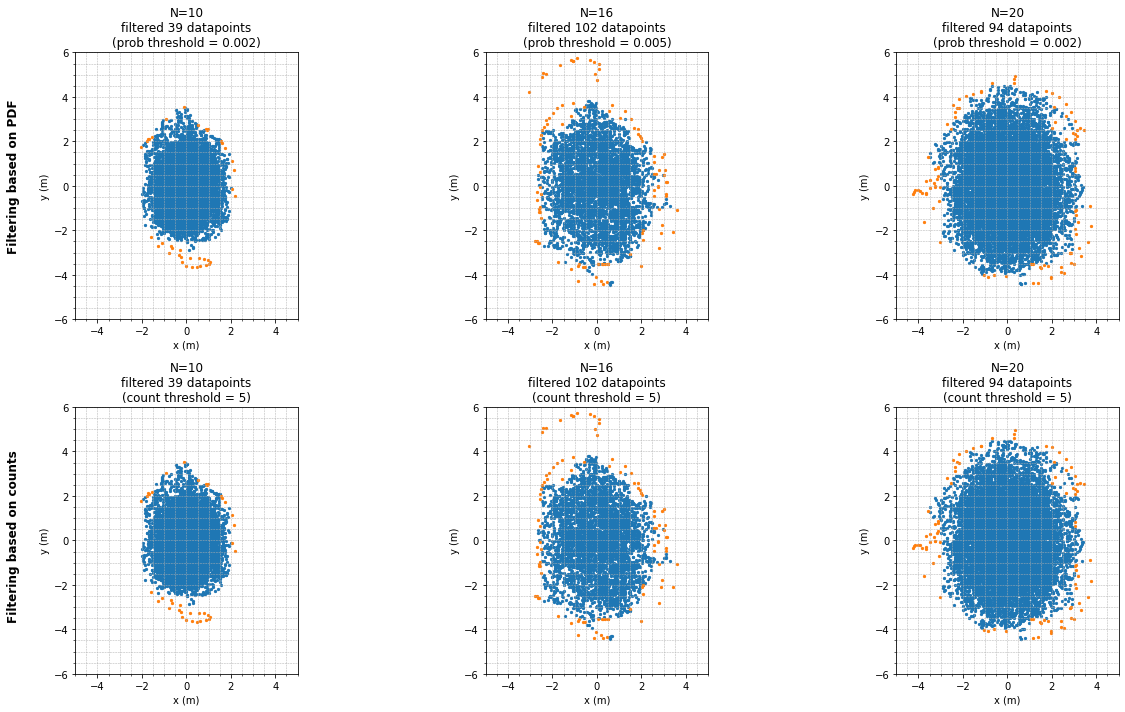

In [ ]:
# Function to classify data points
def classify_data(x, y, xmin, xmax, ymin, ymax, threshold):
    x_edges = np.arange(xmin, xmax + 0.5, 0.5)
    y_edges = np.arange(ymin, ymax + 0.5, 0.5)
    counts, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])
    
    mask = np.zeros(len(x), dtype=bool)

    for ix in range(len(x_edges) - 1):
        for iy in range(len(y_edges) - 1):
            if counts[ix, iy] < threshold:
                cell_mask = (x >= x_edges[ix]) & (x < x_edges[ix + 1]) & (y >= y_edges[iy]) & (y < y_edges[iy + 1])
                mask |= cell_mask

    return ~mask

# Define the range for x and y values
plot_groups = ['N10', 'N16', 'N20']
x_min = np.min([np.min(positions[group]['x']['m']) for group in plot_groups])
x_max = np.max([np.max(positions[group]['x']['m']) for group in plot_groups])
y_min = np.min([np.min(positions[group]['y']['m']) for group in plot_groups])
y_max = np.max([np.max(positions[group]['y']['m']) for group in plot_groups])

x_limit = (int(np.floor(x_min)) - 1, int(np.ceil(x_max)) + 1)
y_limit = (int(np.floor(y_min)) - 1, int(np.ceil(y_max)) + 1)

# Plot scatter plots
unit = 'm'

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# First set of scatter plots
print("plotting all the datapoints when filtering...")
print("    * orange = filtered")
print("    * blue = remaining (used in the spatial heat maps)")

for i, group in enumerate(plot_groups):
    axs[0, i].scatter(positions[group]['x']['m'], positions[group]['y']['m'], 
                      marker='o', c='tab:blue', s=5)
    axs[0, i].scatter(filtered_positions[group]['x']['m'], filtered_positions[group]['y']['m'], 
                      marker='o', c='tab:orange', s=5)
    filtered_cnt = len(filtered_positions[group]['x']['m'])
    axs[0, i].set_title(f'{group[0]}={group[1:]}\nfiltered {filtered_cnt} datapoints\n(prob threshold = {prob_threshold[group]})')
    axs[0, i].set_xlabel('x (m)')
    axs[0, i].set_ylabel('y (m)')
    axs[0, i].set_xlim(x_limit)
    axs[0, i].set_ylim(y_limit)

    axs[0, i].xaxis.set_major_locator(plt.MultipleLocator(2))
    axs[0, i].yaxis.set_major_locator(plt.MultipleLocator(2))
    axs[0, i].xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    axs[0, i].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
    axs[0, i].grid(which='both', linestyle='--', linewidth=0.5)
    axs[0, i].set_aspect('equal')

# Second set of scatter plots
for i, group in enumerate(plot_groups):
    # Get data
    x = positions[group]['x'][unit]
    y = positions[group]['y'][unit]
    filtered_x = filtered_positions[group]['x'][unit]
    filtered_y = filtered_positions[group]['y'][unit]
    all_x = np.concatenate([x, filtered_x])
    all_y = np.concatenate([y, filtered_y])

    mask = classify_data(all_x, all_y, x_limit[0], x_limit[1], y_limit[0], y_limit[1], cnt_threshold)
    
    # Scatter plot with default colors
    axs[1, i].scatter(all_x[mask], all_y[mask], marker='o', c='tab:blue', s=5)
    axs[1, i].scatter(all_x[~mask], all_y[~mask], marker='o', c='tab:orange', s=5)

    filtered_cnt = len(all_x[~mask])
    axs[1, i].set_title(f'{group[0]}={group[1:]}\nfiltered {filtered_cnt} datapoints\n(count threshold = {cnt_threshold})')
    axs[1, i].set_xlabel('x (m)')
    axs[1, i].set_ylabel('y (m)')
    axs[1, i].set_xlim(x_limit)
    axs[1, i].set_ylim(y_limit)

    axs[1, i].xaxis.set_major_locator(plt.MultipleLocator(2))
    axs[1, i].yaxis.set_major_locator(plt.MultipleLocator(2))
    axs[1, i].xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    axs[1, i].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
    axs[1, i].grid(which='both', linestyle='--', linewidth=0.5)
    axs[1, i].set_aspect('equal')

# Add row labels
fig.text(0.05, 0.75, 'Filtering based on PDF', va='center', ha='center', rotation='vertical', fontsize=12, weight='bold')
fig.text(0.05, 0.25, 'Filtering based on counts', va='center', ha='center', rotation='vertical', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

N10 : [0, 12, 22, 31, 39, 44, 56]
N16 : [0, 31, 55, 82, 102, 132, 156]
N20 : [0, 18, 48, 66, 94, 139, 175]


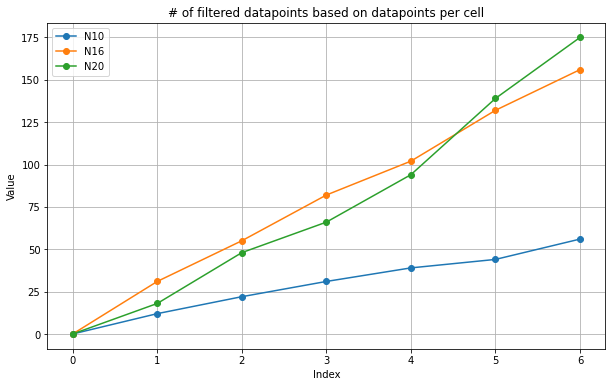

In [ ]:
# Function to count data points in each cell
def count_data_points(x, y, 
                      xmin, xmax, ymin, ymax,
                      threshold):
    x_edges = np.arange(xmin, xmax + 0.5, 0.5)
    y_edges = np.arange(ymin, ymax + 0.5, 0.5)
    counts, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])
    return counts < threshold, counts

# Plot scatter plots
unit = 'm'
threshold = 6  # Adjust threshold as needed

plot_groups = ['N10', 'N16', 'N20']  # Different order from your sample

data = {}
for i, group in enumerate(plot_groups):
    x = positions[group]['x'][unit]
    y = positions[group]['y'][unit]
    filtered_x = filtered_positions[group]['x'][unit]
    filtered_y = filtered_positions[group]['y'][unit]

    data[group] = []
    for thre in range(1,8):
        # Count data points in each cell
        mask, counts = count_data_points(x + filtered_x, y + filtered_y, 
                                x_limit[0], x_limit[1], y_limit[0], y_limit[1],
                                thre)
        data[group].append( int(np.sum(counts[mask])) )
    print(f"{group} : {data[group]}")

x_values = range(len(data[group]))

plt.figure(figsize=(10, 6))
for group in (plot_groups):
    plt.plot(data[group], marker='o', label=group)
plt.title('# of filtered datapoints based on datapoints per cell')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.show()